In [26]:
#!pip install pandas
#!pip install matplotlib

# Importamos librerías
import zipfile
import pandas as pd
import numpy as np
from io import BytesIO
from matplotlib import pyplot as plt

In [6]:
file_path = '/home/maria/Escritorio/TI/DatosSinapsisArtificial'

In [7]:
def zip_to_dataframe(file_path, file_name, names):
    file_path_zip = f'{file_path}/{file_name}.zip'
    file_name_txt = f'{file_name}.txt'
    with zipfile.ZipFile(file_path_zip) as thezip:
        with thezip.open(file_name_txt, mode='r') as thefile:
            data = thefile.read()
            return pd.read_csv(BytesIO(data), sep = '\t', index_col = False, names = names, skiprows=range(3), decimal = ',')

### Análisis TrozoC

In [8]:
filename = 'TrozoC'
names = ['LP','VD']
df_trozo_c = zip_to_dataframe(file_path, filename, names)

In [21]:
print('Number of channels = ', len(df_trozo_c.columns)) # 2
print('Number of samples per channel = ', len(df_trozo_c)) # 19847700
df_trozo_c.describe()

Number of channels =  2
Number of samples per channel =  19847700


,LP,VD
count,1.984770e+07,1.984770e+07
mean,-2.253853e-08,4.385849e-02
std,8.214042e-02,3.287948e-02
min,-7.101440e-01,-2.170715e+00
25%,-2.288800e-02,3.295900e-02
50%,3.050000e-04,4.364000e-02
75%,2.410900e-02,5.401600e-02
max,9.344480e-01,1.351624e+00


In [19]:
df_trozo_c.head()

,LP,VD
0,0.004883,0.015259
1,0.001526,0.024109
2,-0.010681,0.031128
3,-0.022278,0.041809
4,-0.028076,0.045471


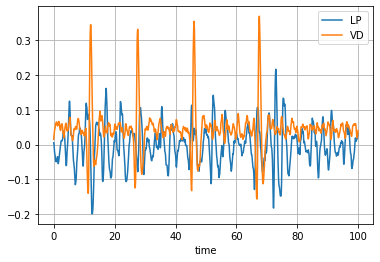

In [78]:
n = 1000
dt = 0.1
t = np.arange(0, n*dt, dt)
plt.plot(t,df_trozo_c['LP'].iloc[:n])
plt.plot(t,df_trozo_c['VD'].iloc[:n])
plt.xlabel('time')
plt.legend(['LP', 'VD'])
plt.grid(True)
plt.show()

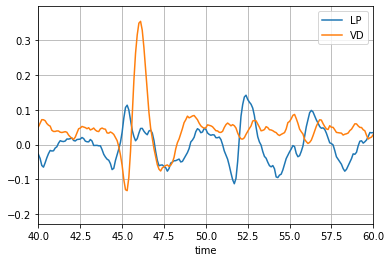

In [81]:
# Representando los valores que hay entre 40 y 60 ya que se aprecia un disparo
n = 1000
dt = 0.1
t = np.arange(0, n*dt, dt)
plt.plot(t,df_trozo_c['LP'].iloc[:n])
plt.plot(t,df_trozo_c['VD'].iloc[:n])
plt.xlim(40, 60)
plt.xlabel('time')
plt.legend(['LP', 'VD'])
plt.grid(True)
plt.show()

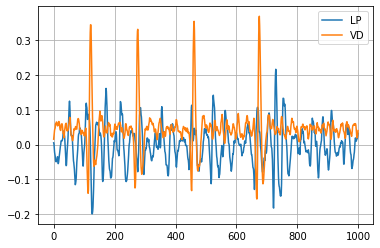

In [84]:
# Representando los n valores sin tener en cuenta los saltos de 0.1 del intervalo
n = 1000
plt.plot(df_trozo_c['LP'].iloc[:n])
plt.plot(df_trozo_c['VD'].iloc[:n])
plt.legend(['LP', 'VD'])
plt.grid(True)
plt.show()

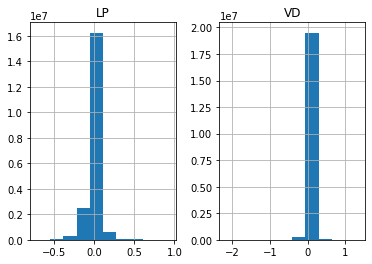

In [72]:
histogram = df_trozo_c.hist()
plt.show()

In [ ]:
## Definir umbral para detectar outlier (i.e. spikes), realizar un kernel gaussiano (repasar transparencias el profe comentó algo de eso)